In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 239318 images
Dataset type val label type: species


Loaded 59836 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 97692 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 nddf6x27


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-nddf6x27:best, 314.57MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:6.5


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                              | 0/1870 [00:00<?, ?it/s]

  0%|                                                                                                                                                      | 1/1870 [00:01<36:50,  1.18s/it]

  0%|▍                                                                                                                                                     | 6/1870 [00:01<05:09,  6.03it/s]

  1%|▉                                                                                                                                                    | 11/1870 [00:01<02:38, 11.70it/s]

  1%|█▎                                                                                                                                                   | 16/1870 [00:01<01:45, 17.59it/s]

  1%|█▋                                                                                                                                                   | 21/1870 [00:01<01:18, 23.43it/s]

  1%|██                                                                                                                                                   | 26/1870 [00:01<01:03, 28.82it/s]

  2%|██▍                                                                                                                                                  | 31/1870 [00:01<00:54, 33.50it/s]

  2%|██▊                                                                                                                                                  | 36/1870 [00:01<00:49, 37.36it/s]

  2%|███▎                                                                                                                                                 | 41/1870 [00:02<00:45, 40.47it/s]

  2%|███▋                                                                                                                                                 | 46/1870 [00:02<00:42, 42.86it/s]

  3%|████                                                                                                                                                 | 51/1870 [00:02<00:40, 44.69it/s]

  3%|████▍                                                                                                                                                | 56/1870 [00:02<00:39, 46.05it/s]

  3%|████▊                                                                                                                                                | 61/1870 [00:02<00:38, 46.97it/s]

  4%|█████▎                                                                                                                                               | 66/1870 [00:02<00:37, 47.67it/s]

  4%|█████▋                                                                                                                                               | 71/1870 [00:02<00:37, 48.11it/s]

  4%|██████                                                                                                                                               | 76/1870 [00:02<00:37, 48.42it/s]

  4%|██████▍                                                                                                                                              | 81/1870 [00:02<00:36, 48.71it/s]

  5%|██████▊                                                                                                                                              | 86/1870 [00:02<00:36, 48.89it/s]

  5%|███████▎                                                                                                                                             | 91/1870 [00:03<00:36, 48.90it/s]

  5%|███████▋                                                                                                                                             | 96/1870 [00:03<00:36, 48.99it/s]

  5%|███████▉                                                                                                                                            | 101/1870 [00:03<00:36, 49.03it/s]

  6%|████████▍                                                                                                                                           | 106/1870 [00:03<00:35, 49.08it/s]

  6%|████████▊                                                                                                                                           | 111/1870 [00:03<00:35, 49.17it/s]

  6%|█████████▏                                                                                                                                          | 116/1870 [00:03<00:35, 49.23it/s]

  6%|█████████▌                                                                                                                                          | 121/1870 [00:03<00:35, 49.28it/s]

  7%|█████████▉                                                                                                                                          | 126/1870 [00:03<00:35, 49.25it/s]

  7%|██████████▎                                                                                                                                         | 131/1870 [00:03<00:35, 49.23it/s]

  7%|██████████▊                                                                                                                                         | 136/1870 [00:03<00:35, 49.23it/s]

  8%|███████████▏                                                                                                                                        | 141/1870 [00:04<00:35, 49.27it/s]

  8%|███████████▌                                                                                                                                        | 146/1870 [00:04<00:34, 49.30it/s]

  8%|███████████▉                                                                                                                                        | 151/1870 [00:04<00:34, 49.20it/s]

  8%|████████████▎                                                                                                                                       | 156/1870 [00:04<00:34, 49.19it/s]

  9%|████████████▋                                                                                                                                       | 161/1870 [00:04<00:34, 49.22it/s]

  9%|█████████████▏                                                                                                                                      | 166/1870 [00:04<00:34, 49.21it/s]

  9%|█████████████▌                                                                                                                                      | 171/1870 [00:04<00:34, 49.23it/s]

  9%|█████████████▉                                                                                                                                      | 176/1870 [00:04<00:34, 49.24it/s]

 10%|██████████████▎                                                                                                                                     | 181/1870 [00:04<00:34, 49.26it/s]

 10%|██████████████▋                                                                                                                                     | 186/1870 [00:04<00:34, 49.27it/s]

 10%|███████████████                                                                                                                                     | 191/1870 [00:05<00:34, 49.31it/s]

 10%|███████████████▌                                                                                                                                    | 196/1870 [00:05<00:33, 49.29it/s]

 11%|███████████████▉                                                                                                                                    | 201/1870 [00:05<00:33, 49.32it/s]

 11%|████████████████▎                                                                                                                                   | 206/1870 [00:05<00:33, 49.30it/s]

 11%|████████████████▋                                                                                                                                   | 211/1870 [00:05<00:33, 49.33it/s]

 12%|█████████████████                                                                                                                                   | 216/1870 [00:05<00:33, 49.31it/s]

 12%|█████████████████▍                                                                                                                                  | 221/1870 [00:05<00:33, 49.07it/s]

 12%|█████████████████▉                                                                                                                                  | 226/1870 [00:05<00:33, 49.12it/s]

 12%|██████████████████▎                                                                                                                                 | 231/1870 [00:05<00:33, 49.19it/s]

 13%|██████████████████▋                                                                                                                                 | 236/1870 [00:05<00:33, 49.23it/s]

 13%|███████████████████▏                                                                                                                                | 242/1870 [00:06<00:32, 49.65it/s]

 13%|███████████████████▋                                                                                                                                | 248/1870 [00:06<00:32, 49.91it/s]

 14%|████████████████████                                                                                                                                | 253/1870 [00:06<00:32, 49.71it/s]

 14%|████████████████████▍                                                                                                                               | 258/1870 [00:06<00:32, 49.52it/s]

 14%|████████████████████▊                                                                                                                               | 263/1870 [00:06<00:32, 49.40it/s]

 14%|█████████████████████▏                                                                                                                              | 268/1870 [00:06<00:32, 49.31it/s]

 15%|█████████████████████▌                                                                                                                              | 273/1870 [00:06<00:32, 49.27it/s]

 15%|██████████████████████                                                                                                                              | 278/1870 [00:06<00:32, 49.30it/s]

 15%|██████████████████████▍                                                                                                                             | 283/1870 [00:06<00:32, 49.31it/s]

 15%|██████████████████████▊                                                                                                                             | 288/1870 [00:07<00:32, 49.30it/s]

 16%|███████████████████████▏                                                                                                                            | 293/1870 [00:07<00:32, 49.24it/s]

 16%|███████████████████████▌                                                                                                                            | 298/1870 [00:07<00:31, 49.17it/s]

 16%|███████████████████████▉                                                                                                                            | 303/1870 [00:07<00:31, 49.18it/s]

 16%|████████████████████████▍                                                                                                                           | 308/1870 [00:07<00:31, 49.21it/s]

 17%|████████████████████████▊                                                                                                                           | 313/1870 [00:07<00:31, 49.28it/s]

 17%|█████████████████████████▏                                                                                                                          | 318/1870 [00:07<00:31, 49.39it/s]

 17%|█████████████████████████▌                                                                                                                          | 323/1870 [00:07<00:31, 48.80it/s]

 18%|█████████████████████████▉                                                                                                                          | 328/1870 [00:07<00:31, 49.04it/s]

 18%|██████████████████████████▎                                                                                                                         | 333/1870 [00:07<00:31, 49.24it/s]

 18%|██████████████████████████▊                                                                                                                         | 338/1870 [00:08<00:31, 49.38it/s]

 18%|███████████████████████████▏                                                                                                                        | 343/1870 [00:08<00:30, 49.47it/s]

 19%|███████████████████████████▌                                                                                                                        | 348/1870 [00:08<00:30, 49.51it/s]

 19%|███████████████████████████▉                                                                                                                        | 353/1870 [00:08<00:30, 49.32it/s]

 19%|████████████████████████████▎                                                                                                                       | 358/1870 [00:08<00:30, 49.26it/s]

 19%|████████████████████████████▋                                                                                                                       | 363/1870 [00:08<00:30, 49.27it/s]

 20%|█████████████████████████████▏                                                                                                                      | 368/1870 [00:08<00:30, 49.33it/s]

 20%|█████████████████████████████▌                                                                                                                      | 373/1870 [00:08<00:30, 49.27it/s]

 20%|█████████████████████████████▉                                                                                                                      | 378/1870 [00:08<00:30, 49.32it/s]

 20%|██████████████████████████████▎                                                                                                                     | 383/1870 [00:08<00:30, 49.39it/s]

 21%|██████████████████████████████▋                                                                                                                     | 388/1870 [00:09<00:29, 49.42it/s]

 21%|███████████████████████████████                                                                                                                     | 393/1870 [00:09<00:29, 49.49it/s]

 21%|███████████████████████████████▍                                                                                                                    | 398/1870 [00:09<00:29, 49.50it/s]

 22%|███████████████████████████████▉                                                                                                                    | 403/1870 [00:09<00:29, 49.36it/s]

 22%|████████████████████████████████▎                                                                                                                   | 409/1870 [00:09<00:29, 49.72it/s]

 22%|████████████████████████████████▊                                                                                                                   | 414/1870 [00:09<00:29, 49.52it/s]

 22%|█████████████████████████████████▏                                                                                                                  | 419/1870 [00:09<00:29, 49.50it/s]

 23%|█████████████████████████████████▌                                                                                                                  | 424/1870 [00:09<00:29, 49.49it/s]

 23%|█████████████████████████████████▉                                                                                                                  | 429/1870 [00:09<00:29, 49.51it/s]

 23%|██████████████████████████████████▎                                                                                                                 | 434/1870 [00:09<00:28, 49.52it/s]

 23%|██████████████████████████████████▋                                                                                                                 | 439/1870 [00:10<00:28, 49.48it/s]

 24%|███████████████████████████████████▏                                                                                                                | 444/1870 [00:10<00:28, 49.48it/s]

 24%|███████████████████████████████████▌                                                                                                                | 449/1870 [00:10<00:28, 49.52it/s]

 24%|███████████████████████████████████▉                                                                                                                | 454/1870 [00:10<00:28, 49.38it/s]

 25%|████████████████████████████████████▍                                                                                                               | 460/1870 [00:10<00:28, 49.76it/s]

 25%|████████████████████████████████████▊                                                                                                               | 465/1870 [00:10<00:28, 49.61it/s]

 25%|█████████████████████████████████████▏                                                                                                              | 470/1870 [00:10<00:28, 49.58it/s]

 25%|█████████████████████████████████████▌                                                                                                              | 475/1870 [00:10<00:28, 49.56it/s]

 26%|█████████████████████████████████████▉                                                                                                              | 480/1870 [00:10<00:28, 49.54it/s]

 26%|██████████████████████████████████████▍                                                                                                             | 485/1870 [00:11<00:27, 49.54it/s]

 26%|██████████████████████████████████████▊                                                                                                             | 490/1870 [00:11<00:27, 49.54it/s]

 26%|███████████████████████████████████████▏                                                                                                            | 495/1870 [00:11<00:27, 49.52it/s]

 27%|███████████████████████████████████████▌                                                                                                            | 500/1870 [00:11<00:27, 49.51it/s]

 27%|███████████████████████████████████████▉                                                                                                            | 505/1870 [00:11<00:27, 49.51it/s]

 27%|████████████████████████████████████████▎                                                                                                           | 510/1870 [00:11<00:27, 49.50it/s]

 28%|████████████████████████████████████████▊                                                                                                           | 515/1870 [00:11<00:27, 49.58it/s]

 28%|█████████████████████████████████████████▏                                                                                                          | 520/1870 [00:11<00:27, 49.50it/s]

 28%|█████████████████████████████████████████▌                                                                                                          | 525/1870 [00:11<00:27, 49.51it/s]

 28%|█████████████████████████████████████████▉                                                                                                          | 530/1870 [00:11<00:27, 49.51it/s]

 29%|██████████████████████████████████████████▎                                                                                                         | 535/1870 [00:12<00:26, 49.52it/s]

 29%|██████████████████████████████████████████▋                                                                                                         | 540/1870 [00:12<00:26, 49.51it/s]

 29%|███████████████████████████████████████████▏                                                                                                        | 545/1870 [00:12<00:26, 49.53it/s]

 29%|███████████████████████████████████████████▌                                                                                                        | 550/1870 [00:12<00:26, 49.57it/s]

 30%|███████████████████████████████████████████▉                                                                                                        | 555/1870 [00:12<00:26, 49.47it/s]

 30%|████████████████████████████████████████████▎                                                                                                       | 560/1870 [00:12<00:26, 49.49it/s]

 30%|████████████████████████████████████████████▋                                                                                                       | 565/1870 [00:12<00:26, 49.44it/s]

 30%|█████████████████████████████████████████████                                                                                                       | 570/1870 [00:12<00:26, 49.50it/s]

 31%|█████████████████████████████████████████████▌                                                                                                      | 575/1870 [00:12<00:26, 49.37it/s]

 31%|█████████████████████████████████████████████▉                                                                                                      | 580/1870 [00:12<00:26, 49.50it/s]

 31%|██████████████████████████████████████████████▎                                                                                                     | 585/1870 [00:13<00:25, 49.59it/s]

 32%|██████████████████████████████████████████████▋                                                                                                     | 590/1870 [00:13<00:25, 49.55it/s]

 32%|███████████████████████████████████████████████                                                                                                     | 595/1870 [00:13<00:25, 49.56it/s]

 32%|███████████████████████████████████████████████▍                                                                                                    | 600/1870 [00:13<00:25, 49.59it/s]

 32%|███████████████████████████████████████████████▉                                                                                                    | 605/1870 [00:13<00:25, 49.55it/s]

 33%|████████████████████████████████████████████████▎                                                                                                   | 610/1870 [00:13<00:25, 49.46it/s]

 33%|████████████████████████████████████████████████▋                                                                                                   | 615/1870 [00:13<00:25, 49.49it/s]

 33%|█████████████████████████████████████████████████                                                                                                   | 620/1870 [00:13<00:25, 49.53it/s]

 33%|█████████████████████████████████████████████████▍                                                                                                  | 625/1870 [00:13<00:25, 49.51it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                  | 630/1870 [00:13<00:25, 49.46it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                 | 635/1870 [00:14<00:24, 49.42it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                 | 640/1870 [00:14<00:24, 49.37it/s]

 34%|███████████████████████████████████████████████████                                                                                                 | 645/1870 [00:14<00:24, 49.40it/s]

 35%|███████████████████████████████████████████████████▍                                                                                                | 650/1870 [00:14<00:24, 49.48it/s]

 35%|███████████████████████████████████████████████████▊                                                                                                | 655/1870 [00:14<00:24, 49.53it/s]

 35%|████████████████████████████████████████████████████▏                                                                                               | 660/1870 [00:14<00:24, 49.47it/s]

 36%|████████████████████████████████████████████████████▋                                                                                               | 665/1870 [00:14<00:24, 49.48it/s]

 36%|█████████████████████████████████████████████████████                                                                                               | 670/1870 [00:14<00:24, 49.52it/s]

 36%|█████████████████████████████████████████████████████▍                                                                                              | 675/1870 [00:14<00:24, 49.53it/s]

 36%|█████████████████████████████████████████████████████▊                                                                                              | 680/1870 [00:14<00:24, 49.53it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                             | 685/1870 [00:15<00:23, 49.40it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                             | 690/1870 [00:15<00:23, 49.39it/s]

 37%|███████████████████████████████████████████████████████                                                                                             | 695/1870 [00:15<00:23, 49.36it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                            | 700/1870 [00:15<00:23, 49.45it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                            | 705/1870 [00:15<00:23, 49.48it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                           | 710/1870 [00:15<00:23, 49.48it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                           | 715/1870 [00:15<00:23, 49.38it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                           | 720/1870 [00:15<00:23, 49.42it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                          | 725/1870 [00:15<00:23, 49.45it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                          | 730/1870 [00:15<00:23, 49.39it/s]

 39%|██████████████████████████████████████████████████████████▏                                                                                         | 735/1870 [00:16<00:22, 49.44it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                         | 740/1870 [00:16<00:22, 49.46it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                         | 745/1870 [00:16<00:22, 49.34it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                        | 750/1870 [00:16<00:22, 49.43it/s]

 40%|███████████████████████████████████████████████████████████▊                                                                                        | 755/1870 [00:16<00:22, 49.50it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                       | 760/1870 [00:16<00:22, 49.55it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                       | 765/1870 [00:16<00:22, 49.58it/s]

 41%|████████████████████████████████████████████████████████████▉                                                                                       | 770/1870 [00:16<00:22, 49.54it/s]

 41%|█████████████████████████████████████████████████████████████▎                                                                                      | 775/1870 [00:16<00:22, 49.59it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                      | 780/1870 [00:16<00:22, 49.47it/s]

 42%|██████████████████████████████████████████████████████████████▏                                                                                     | 785/1870 [00:17<00:21, 49.45it/s]

 42%|██████████████████████████████████████████████████████████████▌                                                                                     | 790/1870 [00:17<00:21, 49.48it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                     | 795/1870 [00:17<00:21, 49.51it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                    | 800/1870 [00:17<00:21, 49.47it/s]

 43%|███████████████████████████████████████████████████████████████▋                                                                                    | 805/1870 [00:17<00:21, 49.52it/s]

 43%|████████████████████████████████████████████████████████████████                                                                                    | 810/1870 [00:17<00:21, 49.55it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                   | 815/1870 [00:17<00:21, 49.55it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                   | 820/1870 [00:17<00:21, 49.53it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                  | 825/1870 [00:17<00:21, 49.53it/s]

 44%|█████████████████████████████████████████████████████████████████▋                                                                                  | 830/1870 [00:17<00:21, 49.45it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                  | 835/1870 [00:18<00:20, 49.48it/s]

 45%|██████████████████████████████████████████████████████████████████▍                                                                                 | 840/1870 [00:18<00:20, 49.48it/s]

 45%|██████████████████████████████████████████████████████████████████▉                                                                                 | 845/1870 [00:18<00:20, 49.52it/s]

 45%|███████████████████████████████████████████████████████████████████▎                                                                                | 850/1870 [00:18<00:20, 49.56it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                                | 855/1870 [00:18<00:20, 49.61it/s]

 46%|████████████████████████████████████████████████████████████████████                                                                                | 860/1870 [00:18<00:20, 49.53it/s]

 46%|████████████████████████████████████████████████████████████████████▍                                                                               | 865/1870 [00:18<00:20, 49.41it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                               | 870/1870 [00:18<00:20, 49.47it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                              | 875/1870 [00:18<00:20, 49.50it/s]

 47%|█████████████████████████████████████████████████████████████████████▋                                                                              | 880/1870 [00:18<00:20, 49.50it/s]

 47%|██████████████████████████████████████████████████████████████████████                                                                              | 885/1870 [00:19<00:19, 49.53it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                             | 890/1870 [00:19<00:19, 49.54it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                             | 895/1870 [00:19<00:19, 49.53it/s]

 48%|███████████████████████████████████████████████████████████████████████▏                                                                            | 900/1870 [00:19<00:19, 49.41it/s]

 48%|███████████████████████████████████████████████████████████████████████▋                                                                            | 905/1870 [00:19<00:19, 49.43it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                            | 910/1870 [00:19<00:19, 49.47it/s]

 49%|████████████████████████████████████████████████████████████████████████▍                                                                           | 915/1870 [00:19<00:19, 49.50it/s]

 49%|████████████████████████████████████████████████████████████████████████▊                                                                           | 920/1870 [00:19<00:19, 49.45it/s]

 49%|█████████████████████████████████████████████████████████████████████████▏                                                                          | 925/1870 [00:19<00:19, 49.55it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                          | 930/1870 [00:20<00:19, 49.47it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                          | 935/1870 [00:20<00:18, 49.36it/s]

 50%|██████████████████████████████████████████████████████████████████████████▍                                                                         | 940/1870 [00:20<00:18, 49.36it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                         | 945/1870 [00:20<00:18, 49.37it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                        | 950/1870 [00:20<00:18, 49.34it/s]

 51%|███████████████████████████████████████████████████████████████████████████▌                                                                        | 955/1870 [00:20<00:18, 49.34it/s]

 51%|███████████████████████████████████████████████████████████████████████████▉                                                                        | 960/1870 [00:20<00:18, 49.34it/s]

 52%|████████████████████████████████████████████████████████████████████████████▎                                                                       | 965/1870 [00:20<00:18, 49.39it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                       | 970/1870 [00:20<00:18, 49.43it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                      | 975/1870 [00:20<00:18, 49.47it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▌                                                                      | 980/1870 [00:21<00:18, 49.40it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                      | 985/1870 [00:21<00:17, 49.35it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                     | 990/1870 [00:21<00:17, 49.31it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▋                                                                     | 995/1870 [00:21<00:17, 49.35it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                    | 1000/1870 [00:21<00:17, 49.41it/s]

 54%|███████████████████████████████████████████████████████████████████████████████                                                                    | 1005/1870 [00:21<00:17, 49.41it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 1010/1870 [00:21<00:17, 49.42it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                   | 1015/1870 [00:21<00:17, 49.49it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1020/1870 [00:21<00:17, 49.43it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1025/1870 [00:21<00:17, 49.42it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1030/1870 [00:22<00:16, 49.42it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1035/1870 [00:22<00:16, 49.50it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1040/1870 [00:22<00:16, 49.44it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                | 1046/1870 [00:22<00:16, 49.66it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▌                                                                | 1051/1870 [00:22<00:16, 49.67it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████                                                                | 1056/1870 [00:22<00:16, 49.55it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                               | 1061/1870 [00:22<00:16, 49.52it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                               | 1066/1870 [00:22<00:16, 49.50it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1071/1870 [00:22<00:16, 49.52it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1076/1870 [00:22<00:16, 49.53it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1081/1870 [00:23<00:15, 49.42it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1086/1870 [00:23<00:15, 49.48it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1091/1870 [00:23<00:15, 49.42it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1096/1870 [00:23<00:15, 49.32it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1101/1870 [00:23<00:15, 49.35it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1106/1870 [00:23<00:15, 49.35it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1111/1870 [00:23<00:15, 49.40it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1116/1870 [00:23<00:15, 49.47it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                           | 1121/1870 [00:23<00:15, 49.54it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1126/1870 [00:23<00:15, 49.54it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1131/1870 [00:24<00:14, 49.43it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1136/1870 [00:24<00:14, 49.34it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1141/1870 [00:24<00:14, 49.40it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████                                                         | 1146/1870 [00:24<00:14, 49.40it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1151/1870 [00:24<00:14, 49.44it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1156/1870 [00:24<00:14, 49.52it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1161/1870 [00:24<00:14, 49.37it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1166/1870 [00:24<00:14, 49.32it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1171/1870 [00:24<00:14, 49.34it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1176/1870 [00:24<00:14, 49.36it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1181/1870 [00:25<00:13, 49.38it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1186/1870 [00:25<00:13, 49.34it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1191/1870 [00:25<00:13, 49.42it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1196/1870 [00:25<00:13, 49.43it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1201/1870 [00:25<00:13, 49.44it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1206/1870 [00:25<00:13, 49.48it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1211/1870 [00:25<00:13, 49.51it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1216/1870 [00:25<00:13, 49.58it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1221/1870 [00:25<00:13, 49.57it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1226/1870 [00:25<00:12, 49.58it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1231/1870 [00:26<00:12, 49.44it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1236/1870 [00:26<00:12, 49.33it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1241/1870 [00:26<00:12, 49.31it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1246/1870 [00:26<00:12, 49.23it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1251/1870 [00:26<00:12, 49.30it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1256/1870 [00:26<00:12, 49.33it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1261/1870 [00:26<00:12, 49.39it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1266/1870 [00:26<00:12, 49.41it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1271/1870 [00:26<00:12, 49.27it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1276/1870 [00:27<00:12, 49.22it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1281/1870 [00:27<00:11, 49.27it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1286/1870 [00:27<00:11, 49.28it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1291/1870 [00:27<00:11, 49.37it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1296/1870 [00:27<00:11, 49.39it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1301/1870 [00:27<00:11, 49.33it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1306/1870 [00:27<00:11, 49.32it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1311/1870 [00:27<00:11, 49.29it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1316/1870 [00:27<00:11, 49.35it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1321/1870 [00:27<00:11, 49.43it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1326/1870 [00:28<00:11, 49.45it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1331/1870 [00:28<00:10, 49.48it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1336/1870 [00:28<00:10, 49.49it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1341/1870 [00:28<00:10, 49.50it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1346/1870 [00:28<00:10, 49.52it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1351/1870 [00:28<00:10, 49.54it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1356/1870 [00:28<00:10, 49.55it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1361/1870 [00:28<00:10, 49.27it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1366/1870 [00:28<00:10, 49.23it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1371/1870 [00:28<00:10, 49.31it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1376/1870 [00:29<00:10, 49.39it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1381/1870 [00:29<00:09, 49.44it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1386/1870 [00:29<00:09, 49.48it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1391/1870 [00:29<00:09, 49.53it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1396/1870 [00:29<00:09, 49.52it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1401/1870 [00:29<00:09, 49.48it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1406/1870 [00:29<00:09, 49.47it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1411/1870 [00:29<00:09, 49.52it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1416/1870 [00:29<00:09, 49.51it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1421/1870 [00:29<00:09, 49.47it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1426/1870 [00:30<00:08, 49.48it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1431/1870 [00:30<00:08, 49.36it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1436/1870 [00:30<00:08, 49.33it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1441/1870 [00:30<00:08, 49.33it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1446/1870 [00:30<00:08, 49.18it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1451/1870 [00:30<00:08, 49.19it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1456/1870 [00:30<00:08, 49.20it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1461/1870 [00:30<00:08, 49.31it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1466/1870 [00:30<00:08, 49.36it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1471/1870 [00:30<00:08, 49.42it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 1476/1870 [00:31<00:07, 49.37it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1481/1870 [00:31<00:07, 49.38it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1486/1870 [00:31<00:07, 49.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1491/1870 [00:31<00:07, 49.50it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1496/1870 [00:31<00:07, 49.44it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1501/1870 [00:31<00:07, 49.47it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1506/1870 [00:31<00:07, 49.47it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1511/1870 [00:31<00:07, 49.49it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1516/1870 [00:31<00:07, 49.45it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1521/1870 [00:31<00:07, 49.35it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1526/1870 [00:32<00:06, 49.32it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1531/1870 [00:32<00:06, 49.37it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1536/1870 [00:32<00:06, 49.33it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1541/1870 [00:32<00:06, 49.38it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1546/1870 [00:32<00:06, 49.35it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1551/1870 [00:32<00:06, 49.43it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1556/1870 [00:32<00:06, 49.39it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1561/1870 [00:32<00:06, 49.39it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1566/1870 [00:32<00:06, 49.47it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1571/1870 [00:32<00:06, 49.47it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1576/1870 [00:33<00:05, 49.50it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1581/1870 [00:33<00:05, 49.50it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1586/1870 [00:33<00:05, 49.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1591/1870 [00:33<00:05, 49.37it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1596/1870 [00:33<00:05, 49.39it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1601/1870 [00:33<00:05, 49.43it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1606/1870 [00:33<00:05, 49.43it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1611/1870 [00:33<00:05, 49.42it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1616/1870 [00:33<00:05, 49.46it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1621/1870 [00:33<00:05, 49.51it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1626/1870 [00:34<00:04, 49.49it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1631/1870 [00:34<00:04, 49.48it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1636/1870 [00:34<00:04, 49.46it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1641/1870 [00:34<00:04, 49.48it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1646/1870 [00:34<00:04, 49.48it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1651/1870 [00:34<00:04, 49.33it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1656/1870 [00:34<00:04, 49.39it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1661/1870 [00:34<00:04, 49.43it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1666/1870 [00:34<00:04, 49.31it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1671/1870 [00:35<00:04, 49.33it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1676/1870 [00:35<00:03, 49.40it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1681/1870 [00:35<00:03, 49.43it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1686/1870 [00:35<00:03, 49.45it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1691/1870 [00:35<00:03, 49.47it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1696/1870 [00:35<00:03, 49.39it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1701/1870 [00:35<00:03, 49.41it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1706/1870 [00:35<00:03, 49.44it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1711/1870 [00:35<00:03, 49.40it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1716/1870 [00:35<00:03, 49.44it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1721/1870 [00:36<00:03, 49.50it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1726/1870 [00:36<00:02, 49.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1731/1870 [00:36<00:02, 49.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1736/1870 [00:36<00:02, 49.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1741/1870 [00:36<00:02, 49.45it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1746/1870 [00:36<00:02, 49.43it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1751/1870 [00:36<00:02, 49.38it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1756/1870 [00:36<00:02, 49.43it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1761/1870 [00:36<00:02, 49.46it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1766/1870 [00:36<00:02, 49.49it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1771/1870 [00:37<00:02, 49.49it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1776/1870 [00:37<00:01, 49.45it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1781/1870 [00:37<00:01, 49.39it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1786/1870 [00:37<00:01, 49.41it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1791/1870 [00:37<00:01, 49.41it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1796/1870 [00:37<00:01, 49.43it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1801/1870 [00:37<00:01, 49.44it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1806/1870 [00:37<00:01, 49.47it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1811/1870 [00:37<00:01, 49.27it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1816/1870 [00:37<00:01, 49.25it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1821/1870 [00:38<00:00, 49.32it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1826/1870 [00:38<00:00, 49.38it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1831/1870 [00:38<00:00, 49.42it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1836/1870 [00:38<00:00, 49.42it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1841/1870 [00:38<00:00, 49.47it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1846/1870 [00:38<00:00, 49.47it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1851/1870 [00:38<00:00, 49.43it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1856/1870 [00:38<00:00, 49.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1861/1870 [00:38<00:00, 49.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1866/1870 [00:38<00:00, 48.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1870/1870 [00:39<00:00, 47.83it/s]

train - OK


  0%|                                                                                                                                                               | 0/468 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                      | 1/468 [00:00<01:59,  3.90it/s]

  1%|█▉                                                                                                                                                     | 6/468 [00:00<00:23, 19.80it/s]

  2%|███▌                                                                                                                                                  | 11/468 [00:00<00:15, 29.37it/s]

  3%|█████▏                                                                                                                                                | 16/468 [00:00<00:12, 35.74it/s]

  4%|██████▋                                                                                                                                               | 21/468 [00:00<00:11, 39.99it/s]

  6%|████████▎                                                                                                                                             | 26/468 [00:00<00:10, 42.85it/s]

  7%|█████████▉                                                                                                                                            | 31/468 [00:00<00:09, 44.83it/s]

  8%|███████████▌                                                                                                                                          | 36/468 [00:00<00:09, 46.16it/s]

  9%|█████████████▏                                                                                                                                        | 41/468 [00:01<00:09, 47.11it/s]

 10%|██████████████▋                                                                                                                                       | 46/468 [00:01<00:08, 47.75it/s]

 11%|████████████████▎                                                                                                                                     | 51/468 [00:01<00:08, 48.17it/s]

 12%|█████████████████▉                                                                                                                                    | 56/468 [00:01<00:08, 48.49it/s]

 13%|███████████████████▌                                                                                                                                  | 61/468 [00:01<00:08, 48.74it/s]

 14%|█████████████████████▏                                                                                                                                | 66/468 [00:01<00:08, 48.87it/s]

 15%|██████████████████████▊                                                                                                                               | 71/468 [00:01<00:08, 48.86it/s]

 16%|████████████████████████▎                                                                                                                             | 76/468 [00:01<00:08, 48.99it/s]

 17%|█████████████████████████▉                                                                                                                            | 81/468 [00:01<00:07, 49.06it/s]

 18%|███████████████████████████▌                                                                                                                          | 86/468 [00:01<00:07, 49.11it/s]

 19%|█████████████████████████████▏                                                                                                                        | 91/468 [00:02<00:07, 49.19it/s]

 21%|██████████████████████████████▊                                                                                                                       | 96/468 [00:02<00:07, 49.24it/s]

 22%|████████████████████████████████▏                                                                                                                    | 101/468 [00:02<00:07, 49.29it/s]

 23%|█████████████████████████████████▋                                                                                                                   | 106/468 [00:02<00:07, 49.30it/s]

 24%|███████████████████████████████████▎                                                                                                                 | 111/468 [00:02<00:07, 49.36it/s]

 25%|████████████████████████████████████▉                                                                                                                | 116/468 [00:02<00:07, 49.33it/s]

 26%|██████████████████████████████████████▌                                                                                                              | 121/468 [00:02<00:07, 49.23it/s]

 27%|████████████████████████████████████████                                                                                                             | 126/468 [00:02<00:06, 49.16it/s]

 28%|█████████████████████████████████████████▋                                                                                                           | 131/468 [00:02<00:06, 49.21it/s]

 29%|███████████████████████████████████████████▎                                                                                                         | 136/468 [00:03<00:06, 49.26it/s]

 30%|████████████████████████████████████████████▉                                                                                                        | 141/468 [00:03<00:06, 49.25it/s]

 31%|██████████████████████████████████████████████▍                                                                                                      | 146/468 [00:03<00:06, 49.24it/s]

 32%|████████████████████████████████████████████████                                                                                                     | 151/468 [00:03<00:06, 49.27it/s]

 33%|█████████████████████████████████████████████████▋                                                                                                   | 156/468 [00:03<00:06, 49.27it/s]

 34%|███████████████████████████████████████████████████▎                                                                                                 | 161/468 [00:03<00:06, 49.32it/s]

 35%|████████████████████████████████████████████████████▊                                                                                                | 166/468 [00:03<00:06, 49.31it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                              | 171/468 [00:03<00:06, 49.20it/s]

 38%|████████████████████████████████████████████████████████                                                                                             | 176/468 [00:03<00:05, 49.13it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                           | 181/468 [00:03<00:05, 49.17it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                         | 186/468 [00:04<00:05, 49.09it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                        | 191/468 [00:04<00:05, 49.14it/s]

 42%|██████████████████████████████████████████████████████████████▍                                                                                      | 196/468 [00:04<00:05, 49.12it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                     | 201/468 [00:04<00:05, 49.17it/s]

 44%|█████████████████████████████████████████████████████████████████▌                                                                                   | 206/468 [00:04<00:05, 49.08it/s]

 45%|███████████████████████████████████████████████████████████████████▏                                                                                 | 211/468 [00:04<00:05, 48.93it/s]

 46%|████████████████████████████████████████████████████████████████████▊                                                                                | 216/468 [00:04<00:05, 48.83it/s]

 47%|██████████████████████████████████████████████████████████████████████▎                                                                              | 221/468 [00:04<00:05, 48.71it/s]

 48%|███████████████████████████████████████████████████████████████████████▉                                                                             | 226/468 [00:04<00:04, 48.67it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                           | 231/468 [00:04<00:04, 48.60it/s]

 50%|███████████████████████████████████████████████████████████████████████████▏                                                                         | 236/468 [00:05<00:04, 48.56it/s]

 51%|████████████████████████████████████████████████████████████████████████████▋                                                                        | 241/468 [00:05<00:04, 48.47it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                      | 246/468 [00:05<00:04, 48.56it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                     | 251/468 [00:05<00:04, 48.66it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▌                                                                   | 256/468 [00:05<00:04, 48.77it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████                                                                  | 261/468 [00:05<00:04, 48.87it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▋                                                                | 266/468 [00:05<00:04, 48.90it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▎                                                              | 271/468 [00:05<00:04, 48.98it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▊                                                             | 276/468 [00:05<00:03, 49.02it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 281/468 [00:05<00:03, 49.08it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 287/468 [00:06<00:03, 49.37it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 292/468 [00:06<00:03, 49.26it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 297/468 [00:06<00:03, 49.25it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 302/468 [00:06<00:03, 49.17it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 307/468 [00:06<00:03, 49.19it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 312/468 [00:06<00:03, 49.22it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 317/468 [00:06<00:03, 49.23it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 322/468 [00:06<00:02, 49.28it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 327/468 [00:06<00:02, 49.35it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 332/468 [00:07<00:02, 49.30it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 337/468 [00:07<00:02, 49.32it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 342/468 [00:07<00:02, 49.35it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 347/468 [00:07<00:02, 49.25it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 352/468 [00:07<00:02, 49.27it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 357/468 [00:07<00:02, 49.22it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 362/468 [00:07<00:02, 49.38it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 367/468 [00:07<00:02, 49.41it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 372/468 [00:07<00:01, 49.44it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 377/468 [00:07<00:01, 49.41it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 382/468 [00:08<00:01, 49.37it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 387/468 [00:08<00:01, 49.27it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 392/468 [00:08<00:01, 49.27it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 397/468 [00:08<00:01, 49.23it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 402/468 [00:08<00:01, 49.27it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 407/468 [00:08<00:01, 49.32it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 412/468 [00:08<00:01, 49.28it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 417/468 [00:08<00:01, 49.29it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 422/468 [00:08<00:00, 49.28it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 427/468 [00:08<00:00, 49.31it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 432/468 [00:09<00:00, 49.34it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 437/468 [00:09<00:00, 49.34it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 442/468 [00:09<00:00, 49.14it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 447/468 [00:09<00:00, 49.11it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 452/468 [00:09<00:00, 49.05it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 457/468 [00:09<00:00, 49.17it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 462/468 [00:09<00:00, 49.32it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 467/468 [00:09<00:00, 49.19it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:09<00:00, 47.39it/s]

val - OK


  0%|                                                                                                                                                               | 0/764 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                      | 1/764 [00:00<03:40,  3.46it/s]

  1%|█▏                                                                                                                                                     | 6/764 [00:00<00:41, 18.39it/s]

  1%|██▏                                                                                                                                                   | 11/764 [00:00<00:26, 28.02it/s]

  2%|███▏                                                                                                                                                  | 16/764 [00:00<00:21, 34.60it/s]

  3%|████                                                                                                                                                  | 21/764 [00:00<00:18, 39.16it/s]

  3%|█████                                                                                                                                                 | 26/764 [00:00<00:17, 42.28it/s]

  4%|██████                                                                                                                                                | 31/764 [00:00<00:16, 44.47it/s]

  5%|███████                                                                                                                                               | 36/764 [00:01<00:15, 45.92it/s]

  5%|████████                                                                                                                                              | 41/764 [00:01<00:15, 47.03it/s]

  6%|█████████                                                                                                                                             | 46/764 [00:01<00:15, 47.81it/s]

  7%|██████████                                                                                                                                            | 51/764 [00:01<00:14, 48.25it/s]

  7%|██████████▉                                                                                                                                           | 56/764 [00:01<00:14, 48.53it/s]

  8%|███████████▉                                                                                                                                          | 61/764 [00:01<00:14, 48.70it/s]

  9%|████████████▉                                                                                                                                         | 66/764 [00:01<00:14, 48.92it/s]

  9%|█████████████▉                                                                                                                                        | 71/764 [00:01<00:14, 49.08it/s]

 10%|██████████████▉                                                                                                                                       | 76/764 [00:01<00:13, 49.22it/s]

 11%|███████████████▉                                                                                                                                      | 81/764 [00:01<00:13, 49.32it/s]

 11%|████████████████▉                                                                                                                                     | 86/764 [00:02<00:13, 49.35it/s]

 12%|█████████████████▊                                                                                                                                    | 91/764 [00:02<00:13, 49.38it/s]

 13%|██████████████████▊                                                                                                                                   | 96/764 [00:02<00:13, 49.41it/s]

 13%|███████████████████▋                                                                                                                                 | 101/764 [00:02<00:13, 49.46it/s]

 14%|████████████████████▋                                                                                                                                | 106/764 [00:02<00:13, 49.48it/s]

 15%|█████████████████████▋                                                                                                                               | 111/764 [00:02<00:13, 49.51it/s]

 15%|██████████████████████▌                                                                                                                              | 116/764 [00:02<00:13, 49.44it/s]

 16%|███████████████████████▌                                                                                                                             | 121/764 [00:02<00:13, 49.23it/s]

 16%|████████████████████████▌                                                                                                                            | 126/764 [00:02<00:12, 49.32it/s]

 17%|█████████████████████████▌                                                                                                                           | 131/764 [00:02<00:12, 49.43it/s]

 18%|██████████████████████████▌                                                                                                                          | 136/764 [00:03<00:12, 49.42it/s]

 18%|███████████████████████████▍                                                                                                                         | 141/764 [00:03<00:12, 49.44it/s]

 19%|████████████████████████████▍                                                                                                                        | 146/764 [00:03<00:12, 49.48it/s]

 20%|█████████████████████████████▍                                                                                                                       | 151/764 [00:03<00:12, 49.49it/s]

 20%|██████████████████████████████▍                                                                                                                      | 156/764 [00:03<00:12, 49.52it/s]

 21%|███████████████████████████████▍                                                                                                                     | 161/764 [00:03<00:12, 49.54it/s]

 22%|████████████████████████████████▎                                                                                                                    | 166/764 [00:03<00:12, 49.51it/s]

 22%|█████████████████████████████████▎                                                                                                                   | 171/764 [00:03<00:11, 49.56it/s]

 23%|██████████████████████████████████▎                                                                                                                  | 176/764 [00:03<00:11, 49.43it/s]

 24%|███████████████████████████████████▎                                                                                                                 | 181/764 [00:03<00:11, 49.44it/s]

 24%|████████████████████████████████████▎                                                                                                                | 186/764 [00:04<00:11, 49.48it/s]

 25%|█████████████████████████████████████▎                                                                                                               | 191/764 [00:04<00:11, 49.45it/s]

 26%|██████████████████████████████████████▏                                                                                                              | 196/764 [00:04<00:11, 49.43it/s]

 26%|███████████████████████████████████████▏                                                                                                             | 201/764 [00:04<00:11, 49.44it/s]

 27%|████████████████████████████████████████▏                                                                                                            | 206/764 [00:04<00:11, 49.50it/s]

 28%|█████████████████████████████████████████▏                                                                                                           | 211/764 [00:04<00:11, 49.50it/s]

 28%|██████████████████████████████████████████▏                                                                                                          | 216/764 [00:04<00:11, 49.47it/s]

 29%|███████████████████████████████████████████                                                                                                          | 221/764 [00:04<00:10, 49.51it/s]

 30%|████████████████████████████████████████████                                                                                                         | 226/764 [00:04<00:10, 49.44it/s]

 30%|█████████████████████████████████████████████                                                                                                        | 231/764 [00:04<00:10, 49.49it/s]

 31%|██████████████████████████████████████████████                                                                                                       | 236/764 [00:05<00:10, 49.39it/s]

 32%|███████████████████████████████████████████████                                                                                                      | 241/764 [00:05<00:10, 49.45it/s]

 32%|███████████████████████████████████████████████▉                                                                                                     | 246/764 [00:05<00:10, 49.48it/s]

 33%|████████████████████████████████████████████████▉                                                                                                    | 251/764 [00:05<00:10, 49.48it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                   | 256/764 [00:05<00:10, 49.58it/s]

 34%|██████████████████████████████████████████████████▉                                                                                                  | 261/764 [00:05<00:10, 49.51it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                 | 266/764 [00:05<00:10, 49.42it/s]

 35%|████████████████████████████████████████████████████▊                                                                                                | 271/764 [00:05<00:09, 49.43it/s]

 36%|█████████████████████████████████████████████████████▊                                                                                               | 276/764 [00:05<00:09, 49.47it/s]

 37%|██████████████████████████████████████████████████████▊                                                                                              | 281/764 [00:05<00:09, 49.45it/s]

 37%|███████████████████████████████████████████████████████▊                                                                                             | 286/764 [00:06<00:09, 49.58it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                            | 291/764 [00:06<00:09, 49.48it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                           | 296/764 [00:06<00:09, 49.42it/s]

 39%|██████████████████████████████████████████████████████████▋                                                                                          | 301/764 [00:06<00:09, 49.41it/s]

 40%|███████████████████████████████████████████████████████████▋                                                                                         | 306/764 [00:06<00:09, 49.45it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                        | 311/764 [00:06<00:09, 49.45it/s]

 41%|█████████████████████████████████████████████████████████████▋                                                                                       | 316/764 [00:06<00:09, 49.48it/s]

 42%|██████████████████████████████████████████████████████████████▌                                                                                      | 321/764 [00:06<00:08, 49.49it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                     | 326/764 [00:06<00:08, 49.49it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                    | 331/764 [00:06<00:08, 49.44it/s]

 44%|█████████████████████████████████████████████████████████████████▌                                                                                   | 336/764 [00:07<00:08, 49.44it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                  | 341/764 [00:07<00:08, 49.51it/s]

 45%|███████████████████████████████████████████████████████████████████▍                                                                                 | 346/764 [00:07<00:08, 49.51it/s]

 46%|████████████████████████████████████████████████████████████████████▍                                                                                | 351/764 [00:07<00:08, 49.42it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                               | 356/764 [00:07<00:08, 49.43it/s]

 47%|██████████████████████████████████████████████████████████████████████▍                                                                              | 361/764 [00:07<00:08, 49.43it/s]

 48%|███████████████████████████████████████████████████████████████████████▍                                                                             | 366/764 [00:07<00:08, 49.43it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                            | 371/764 [00:07<00:07, 49.46it/s]

 49%|█████████████████████████████████████████████████████████████████████████▎                                                                           | 376/764 [00:07<00:07, 49.45it/s]

 50%|██████████████████████████████████████████████████████████████████████████▎                                                                          | 381/764 [00:07<00:07, 49.51it/s]

 51%|███████████████████████████████████████████████████████████████████████████▎                                                                         | 386/764 [00:08<00:07, 49.50it/s]

 51%|████████████████████████████████████████████████████████████████████████████▎                                                                        | 391/764 [00:08<00:07, 49.47it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                       | 396/764 [00:08<00:07, 49.52it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▏                                                                      | 401/764 [00:08<00:07, 49.49it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▏                                                                     | 406/764 [00:08<00:07, 49.59it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▏                                                                    | 411/764 [00:08<00:07, 49.50it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                   | 416/764 [00:08<00:07, 49.55it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████                                                                   | 421/764 [00:08<00:06, 49.54it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████                                                                  | 426/764 [00:08<00:06, 49.50it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████                                                                 | 431/764 [00:08<00:06, 49.50it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████                                                                | 436/764 [00:09<00:06, 49.50it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████                                                               | 441/764 [00:09<00:06, 49.50it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                              | 446/764 [00:09<00:06, 49.57it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▉                                                             | 451/764 [00:09<00:06, 49.49it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 456/764 [00:09<00:06, 49.39it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 461/764 [00:09<00:06, 49.50it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 466/764 [00:09<00:06, 49.45it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 471/764 [00:09<00:05, 49.44it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 476/764 [00:09<00:05, 49.42it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 481/764 [00:10<00:05, 49.37it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 486/764 [00:10<00:05, 49.41it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 491/764 [00:10<00:05, 49.45it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 496/764 [00:10<00:05, 49.51it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 501/764 [00:10<00:05, 49.53it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 506/764 [00:10<00:05, 49.42it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 511/764 [00:10<00:05, 49.22it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 517/764 [00:10<00:04, 49.63it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 522/764 [00:10<00:04, 49.56it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 527/764 [00:10<00:04, 49.58it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 532/764 [00:11<00:04, 49.48it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 537/764 [00:11<00:04, 49.38it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 542/764 [00:11<00:04, 49.41it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 547/764 [00:11<00:04, 49.45it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 552/764 [00:11<00:04, 49.46it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 557/764 [00:11<00:04, 49.49it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 562/764 [00:11<00:04, 49.41it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 567/764 [00:11<00:03, 49.37it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 572/764 [00:11<00:03, 49.44it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 577/764 [00:11<00:03, 49.38it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 583/764 [00:12<00:03, 49.61it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 588/764 [00:12<00:03, 49.60it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 593/764 [00:12<00:03, 49.43it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 598/764 [00:12<00:03, 49.38it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 603/764 [00:12<00:03, 49.37it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 608/764 [00:12<00:03, 49.40it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 613/764 [00:12<00:03, 49.45it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 618/764 [00:12<00:02, 49.48it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 623/764 [00:12<00:02, 49.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 628/764 [00:12<00:02, 49.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 633/764 [00:13<00:02, 49.50it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 638/764 [00:13<00:02, 49.48it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 643/764 [00:13<00:02, 49.47it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 648/764 [00:13<00:02, 49.31it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 653/764 [00:13<00:02, 49.51it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 658/764 [00:13<00:02, 49.37it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 663/764 [00:13<00:02, 49.43it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 668/764 [00:13<00:01, 49.36it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 673/764 [00:13<00:01, 49.32it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 678/764 [00:13<00:01, 49.34it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 683/764 [00:14<00:01, 49.38it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 688/764 [00:14<00:01, 49.43it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 693/764 [00:14<00:01, 49.46it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 698/764 [00:14<00:01, 49.35it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 703/764 [00:14<00:01, 49.35it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 708/764 [00:14<00:01, 49.38it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 713/764 [00:14<00:01, 49.29it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 718/764 [00:14<00:00, 49.28it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 723/764 [00:14<00:00, 49.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 728/764 [00:15<00:00, 49.25it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 733/764 [00:15<00:00, 49.39it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 738/764 [00:15<00:00, 49.39it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 743/764 [00:15<00:00, 49.31it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 748/764 [00:15<00:00, 49.28it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 753/764 [00:15<00:00, 49.34it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 758/764 [00:15<00:00, 49.42it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 763/764 [00:15<00:00, 49.22it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 764/764 [00:15<00:00, 48.19it/s]

test InD - OK


  0%|                                                                                                                                                               | 0/100 [00:00<?, ?it/s]

  6%|█████████                                                                                                                                              | 6/100 [00:00<00:01, 51.37it/s]

 12%|██████████████████                                                                                                                                    | 12/100 [00:00<00:01, 50.93it/s]

 18%|███████████████████████████                                                                                                                           | 18/100 [00:00<00:01, 50.84it/s]

 24%|████████████████████████████████████                                                                                                                  | 24/100 [00:00<00:01, 50.89it/s]

 30%|█████████████████████████████████████████████                                                                                                         | 30/100 [00:00<00:01, 50.88it/s]

 36%|██████████████████████████████████████████████████████                                                                                                | 36/100 [00:00<00:01, 50.89it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                       | 42/100 [00:00<00:01, 50.90it/s]

 48%|████████████████████████████████████████████████████████████████████████                                                                              | 48/100 [00:00<00:01, 50.93it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                     | 54/100 [00:01<00:00, 50.97it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                            | 60/100 [00:01<00:00, 50.99it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 66/100 [00:01<00:00, 50.99it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 72/100 [00:01<00:00, 50.99it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 78/100 [00:01<00:00, 50.99it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 84/100 [00:01<00:00, 50.99it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 90/100 [00:01<00:00, 50.95it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:01<00:00, 50.97it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.95it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(239318, 3, 64, 64) (239318, 2048) (239318, 512) (239318, 4) (239318,)
(59836, 3, 64, 64) (59836, 2048) (59836, 512) (59836, 4) (59836,)
(97692, 3, 64, 64) (97692, 2048) (97692, 512) (97692, 4) (97692,)
(12800, 3, 64, 64) (12800, 2048) (12800, 512) (12800, 4)


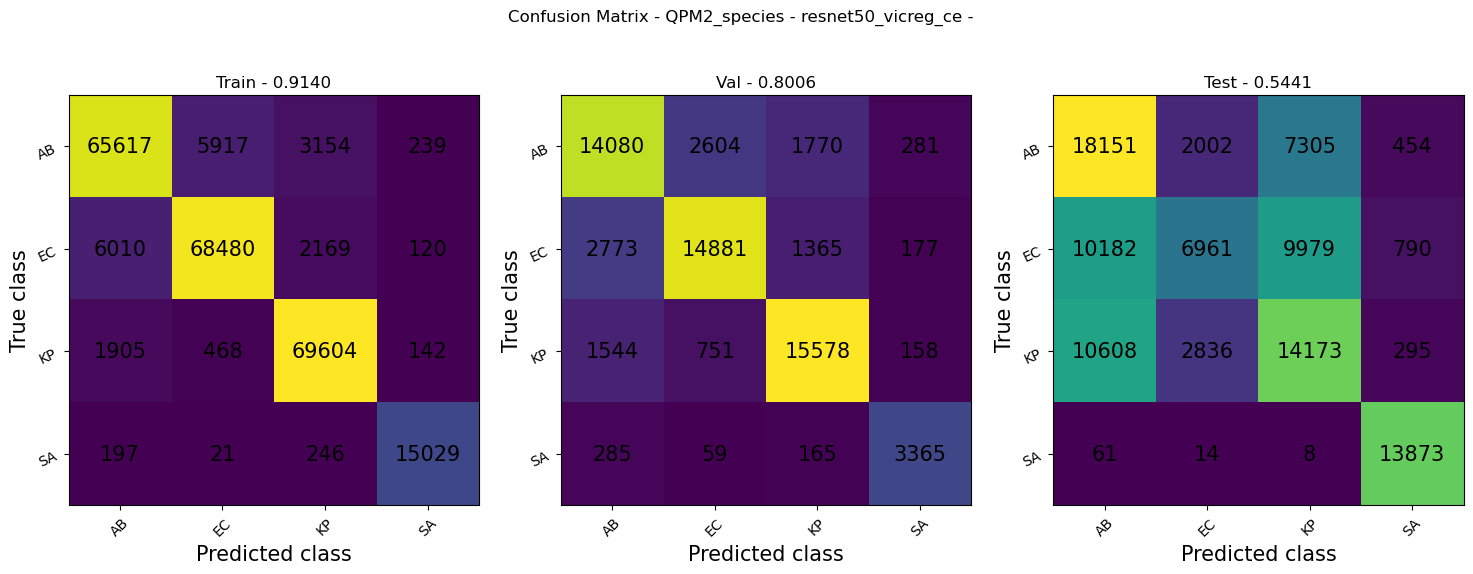

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_ftr2d = umap.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(97692, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(97692, 2) (0, 2)


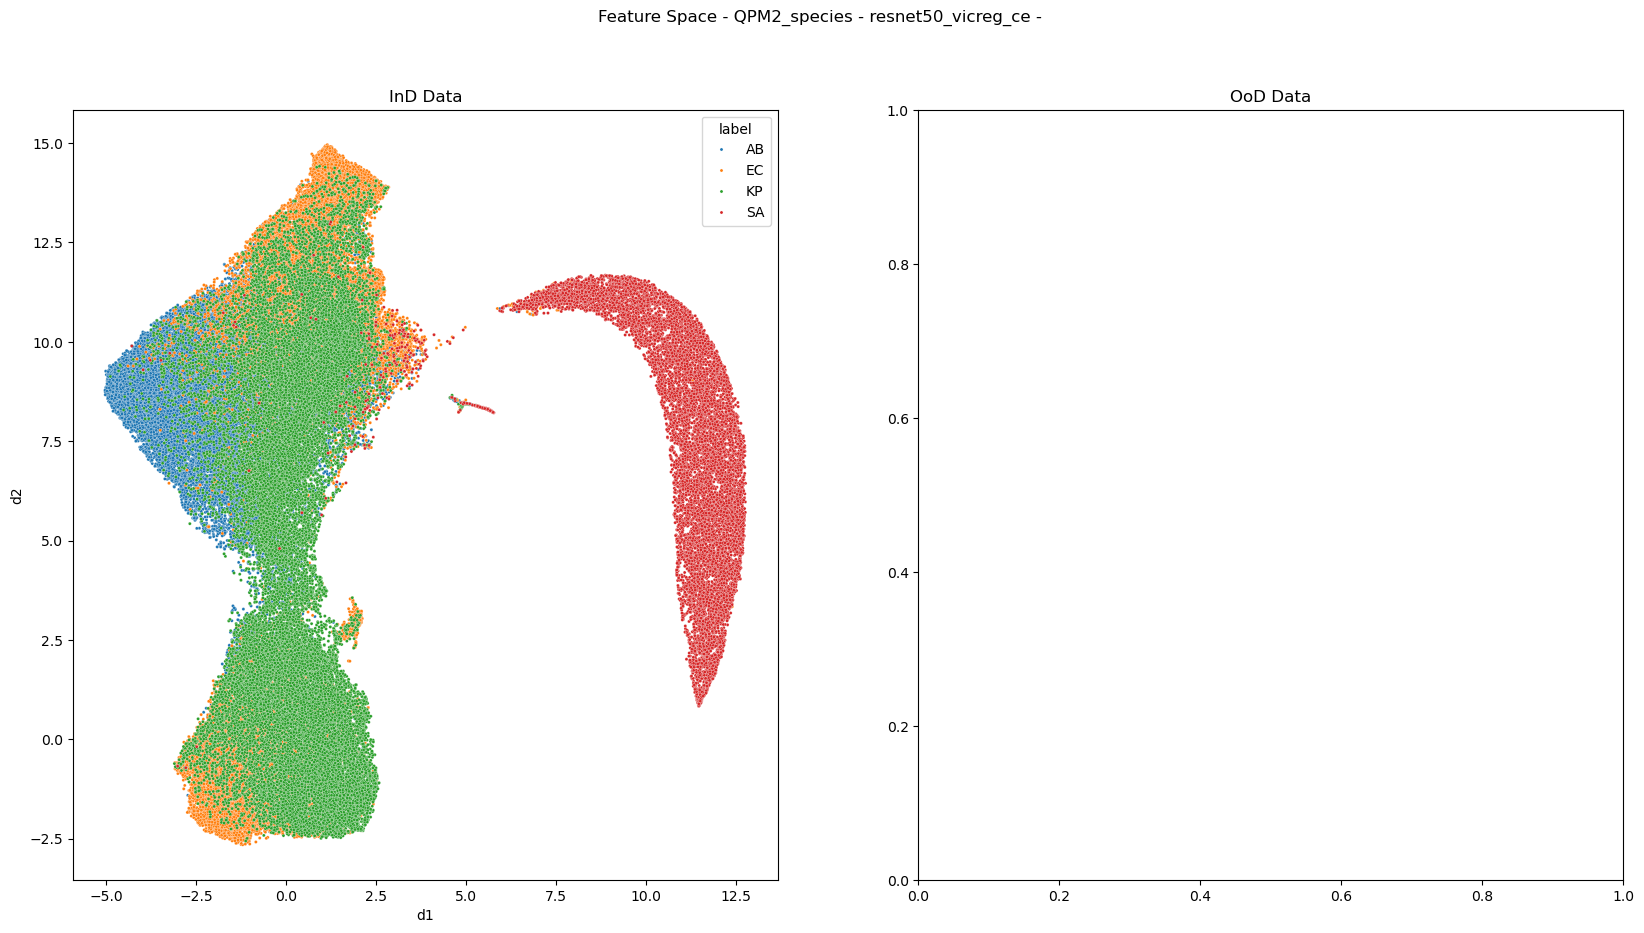

In [13]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

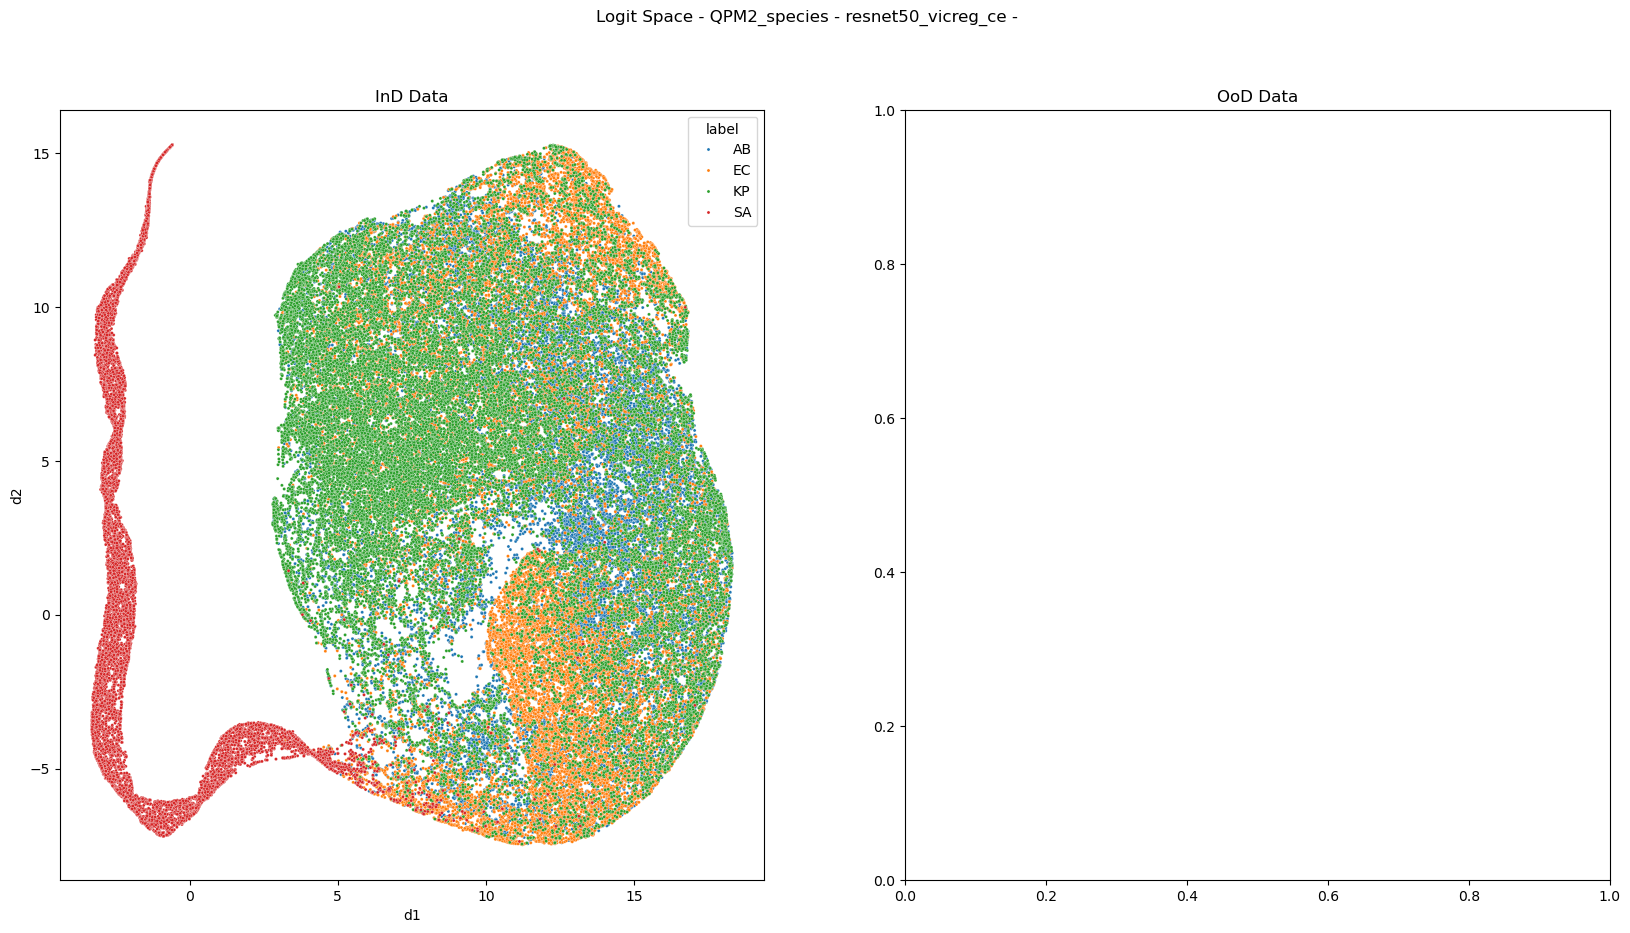

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

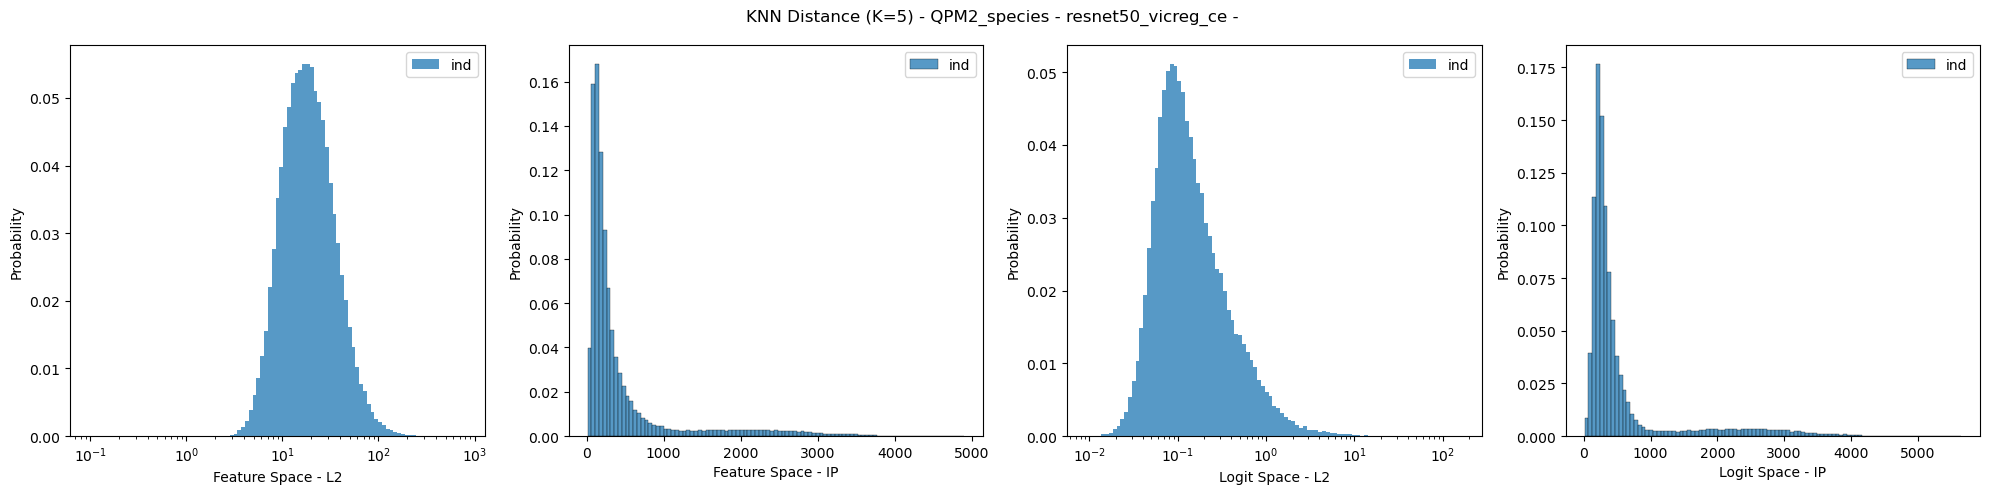

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

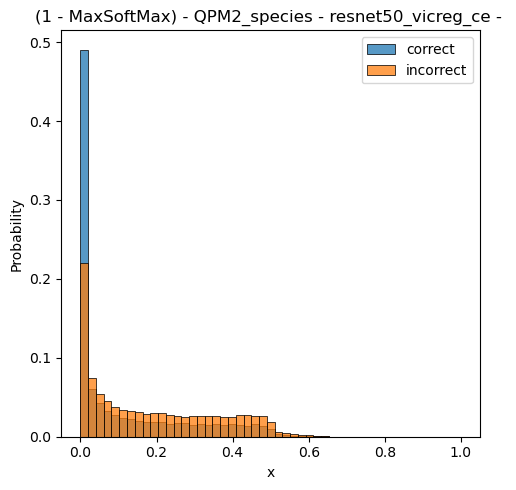

In [16]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [17]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)